In [1]:
import sentencepiece as spm

# Load the trained BPE tokenizer
bpe_tokenizer = spm.SentencePieceProcessor()
bpe_tokenizer.load('../tokenizer/spbpe_isc.model')

True

In [2]:
import morfessor

io = morfessor.MorfessorIO()
morfessor_model = morfessor.BaselineModel()

# load Morfessor model 
morfessor_model = io.read_binary_model_file('../morfessor/morf_isc_model.bin')

In [3]:
def segment_bpe(sentence, tokenizer):
    # SentencePiece BPE segmentation
    return tokenizer.encode(sentence, out_type=str)

def segment_morfessor(sentence, model):
    # Morfessor segmentation
    words = sentence.split()
    segmented_words = []
    for word in words:
        segments = model.viterbi_segment(word)[0]
        segmented_words.extend(segments)
    return segmented_words

In [4]:
sentences = []

with open('../data/isc_sentences.txt', 'r') as f:
    sentences = f.readlines()

In [5]:
sentences_bpe = [segment_bpe(sentence, bpe_tokenizer) for sentence in sentences]
sentences_morfessor = [segment_morfessor(sentence, morfessor_model) for sentence in sentences]

In [7]:

from sklearn.model_selection import train_test_split
# Step 1: Split tokenized_bpe into train and test sets
train_data, test_data = train_test_split(sentences_bpe, test_size=0.2)

# Train

In [9]:
from transformers import BertTokenizer

# Initialize mBERT tokenizer
mbert_tokenizerBPE = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")

# Tokenize segmented sentences for mBERT
def prepare_tokenized_inputs(sentences_segmented):
    tokenized_data = []
    for sentence in sentences_segmented:
        # Join segments with space (as if reconstructing sentence with segmented tokens)
        segmented_text = " ".join(sentence)
        tokenized_data.append(mbert_tokenizerBPE(segmented_text, padding="max_length", truncation=True, max_length=128, return_tensors="pt"))
    return tokenized_data

# Apply tokenization
tokenized_bpe = prepare_tokenized_inputs(train_data)
# tokenized_morfessor = prepare_tokenized_inputs(sentences_morfessor)

In [8]:
from transformers import BertForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset

# Convert data to Hugging Face Dataset format for training
dataset = Dataset.from_dict({
    "input_ids": [data["input_ids"].squeeze(0) for data in tokenized_bpe],
    "attention_mask": [data["attention_mask"].squeeze(0) for data in tokenized_bpe],
})

# Use DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=mbert_tokenizerBPE,
    mlm_probability=0.15,  # 15% masking probability
)

# Load mBERT model
modelBPE = BertForMaskedLM.from_pretrained("bert-base-multilingual-uncased")

# Define training arguments, with checkpoint-saving configurations
training_args = TrainingArguments(
    output_dir="./mbert_BPE",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps
    save_steps=500,
    save_total_limit=2,
    logging_dir='./logs',
    fp16=True,
    no_cuda=False  # This allows GPU if available, otherwise fall back to CPU
)

# Initialize the Trainer for fine-tuning
trainer = Trainer(
    model=modelBPE,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator,
)

# Fine-tune the model (checkpoints will automatically be saved at specified steps)
trainer.train()

# Save the final model and tokenizer
modelBPE.save_pretrained("./mbert_BPE")
mbert_tokenizerBPE.save_pretrained("./mbert_BPE")

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dens

Step,Training Loss


KeyboardInterrupt: 

In [7]:
import torch
torch.cuda.memory_allocated()

0

# Embeddings

In [16]:
from transformers import BertForMaskedLM, BertTokenizer

# Load the trained model and tokenizer
model = BertForMaskedLM.from_pretrained("./mbert_BPE", output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("./mbert_BPE")

/home/atrujillo/langmodels/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [8]:
words = [" ".join(subwords) for subwords in sentences_bpe]

In [ ]:
import torch

# obtain embeddings for words
def get_word_embedding_with_bpe(model, tokenizer, word, bpe_tokenizer, aggregation_method="sum"):
    """
    Get the embedding for a single word, segmented with BPE.
    
    Args:
        model: Pretrained model used for embeddings.
        tokenizer: Tokenizer corresponding to the model.
        word (str): The word to be embedded.
        bpe_tokenizer: SentencePiece or BPE tokenizer for segmentation.
        aggregation_method (str): Method to aggregate subword embeddings.
                                  Options: "mean" (default), "sum", "max".
    
    Returns:
        torch.Tensor: Aggregated embedding for the input word.
    """
    # Segment the word into subwords using BPE
    bpe_subwords = bpe_tokenizer.encode(word, out_type=str)  # Segment using BPE
    segmented_word = " ".join(bpe_subwords)  # Join subwords into a single string

    # Tokenize the segmented word for the model
    inputs = tokenizer(segmented_word, return_tensors="pt", truncation=True)
    
    with torch.no_grad():
        # Get model outputs
        outputs = model(**inputs)
    
    # Extract hidden states (last layer)
    hidden_states = outputs.hidden_states[-1]  # Shape: (batch_size, seq_length, hidden_dim)

    # Remove batch dimension
    subword_embeddings = hidden_states.squeeze(0)  # Shape: (num_subwords, hidden_dim)
    
    # Aggregate subword embeddings
    if aggregation_method == "mean":
        word_embedding = subword_embeddings.mean(dim=0)  # Average pooling
    elif aggregation_method == "sum":
        word_embedding = subword_embeddings.sum(dim=0)  # Sum pooling
    elif aggregation_method == "max":
        word_embedding, _ = subword_embeddings.max(dim=0)  # Max pooling
    else:
        raise ValueError(f"Unsupported aggregation method: {aggregation_method}")
    
    return word_embedding

In [19]:
word = "haton"

# Get embedding for the word
embedding = get_word_embedding_with_bpe(model, tokenizer, word, bpe_tokenizer, aggregation_method="sum")

print(embedding.shape)

torch.Size([768])


In [50]:
def get_unique_words(sentences):
    words = set()
    for sentence in sentences:
        words.update(sentence.strip().split())
    return list(words)

unique_words = get_unique_words(sentences)

# Select 20 random words
import random
selected_words = random.sample(unique_words, 20)

# Get embeddings
def get_word_embeddings(words, model, tokenizer):
    embeddings = []
    for word in words:
        embedding = get_word_embedding_with_bpe(model, tokenizer, word, bpe_tokenizer, aggregation_method="max")  # Assuming function is defined
        embeddings.append(embedding)
    return embeddings

word_vectors = get_word_embeddings(selected_words, model, tokenizer)

In [51]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings_2D(words, vectors, dimension='tsne'):
    """Visualize word vectors in 2D using t-SNE or PCA."""
    # Reduce dimensionality using t-SNE
    if dimension == 'tsne':
        perplexity = min(30, len(words) - 1)  # Ensure perplexity is less than the number of samples
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
        reduced_vectors = tsne.fit_transform(vectors)
    # Reduce dimensionality using PCA
    # elif dimension == 'pca':
    #     pca = PCA(n_components=2)
    #     reduced_vectors = pca.fit_transform(vectors)
    else:
        raise ValueError("Invalid dimension specified. Use 'tsne' or 'pca'.")

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])

    # Annotate each point with the corresponding word
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=9)

    plt.title(f'Visualización 2D de los vectores - mBERT ({dimension.upper()})')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.grid()
    plt.show()

In [52]:
import numpy as np

# Convert word embeddings (list of tensors) to a 2D numpy array
def embeddings_to_numpy(word_vectors):
    # Stack tensors into a numpy array
    return np.vstack([embedding.numpy() for embedding in word_vectors])

# Convert word_vectors list into numpy array
word_vectors_np = embeddings_to_numpy(word_vectors)

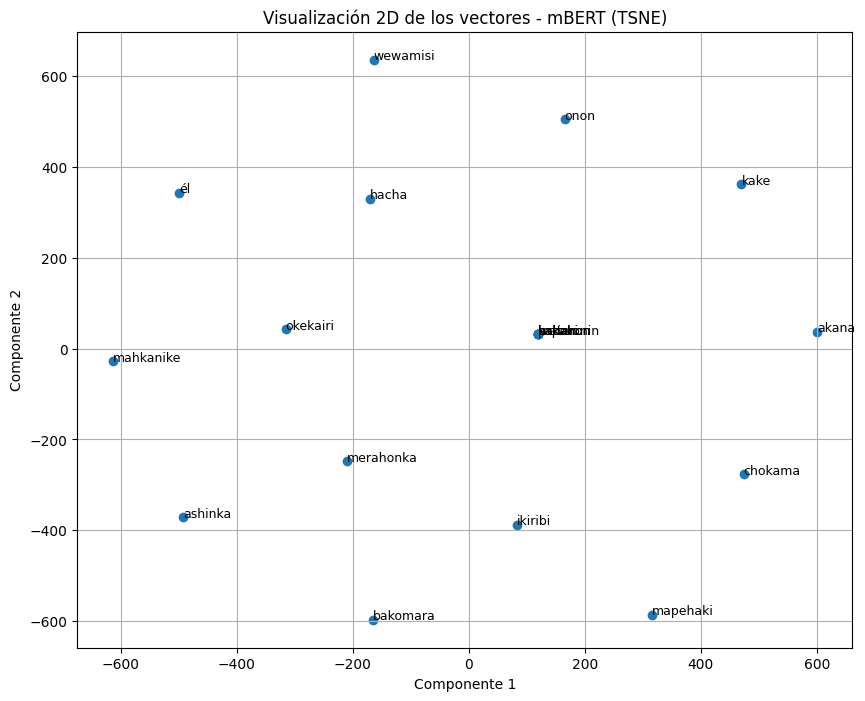

In [53]:
visualize_embeddings_2D(selected_words, word_vectors_np, dimension='tsne')

In [ ]:
'penen',
 'xoxoai',
 'ewekasai',

In [70]:
embedding = get_word_embedding_with_bpe(model, tokenizer, 'penen', bpe_tokenizer, aggregation_method="sum")

▁penen


In [59]:
embedding

tensor([-2.5153e+00,  7.9027e-02,  2.3276e-01,  5.0219e-01, -1.2233e+00,
         8.4892e-01,  4.2895e-01, -9.0510e-01, -1.7267e+00, -2.5598e-01,
        -2.1635e+00,  1.3284e+00, -3.6679e-01, -1.1590e+00,  3.0493e-01,
        -1.0857e+00,  1.5692e+00, -4.5965e-01,  4.2346e-01,  1.1239e+00,
        -9.6299e-01,  3.5491e-01,  9.1542e-01, -8.3450e-01, -2.3617e-01,
        -2.5464e-01, -7.6568e-01,  1.1846e+00,  3.0013e-02, -1.7850e-01,
        -1.8626e+00, -5.1124e-01, -4.3504e-01,  3.0020e-01,  2.0993e+00,
        -1.5453e+00, -2.0496e+00,  1.2942e+00,  1.1990e+00, -1.3655e+00,
        -1.5062e+00,  2.7977e-02,  7.2432e-01, -3.3029e-01, -1.2466e+00,
         1.3549e+00,  7.7492e-01,  2.6575e-01,  8.3675e-01,  6.6842e-01,
        -1.3062e+00,  1.0206e+00,  1.0181e+00, -1.5628e+00, -8.0260e-01,
        -2.0211e-01,  1.8361e+00, -1.1098e-04, -1.0661e+00, -4.2372e-01,
         2.8513e+00, -1.3714e+00,  8.4333e-01,  1.7192e+00, -1.0184e+00,
        -1.3437e+00,  1.5731e+00, -1.1144e+00, -6.6

In [49]:
embedding2

tensor([-2.5153e+00,  7.9027e-02,  2.3276e-01,  5.0219e-01, -1.2233e+00,
         8.4892e-01,  4.2895e-01, -9.0510e-01, -1.7267e+00, -2.5598e-01,
        -2.1635e+00,  1.3284e+00, -3.6679e-01, -1.1590e+00,  3.0493e-01,
        -1.0857e+00,  1.5692e+00, -4.5965e-01,  4.2346e-01,  1.1239e+00,
        -9.6299e-01,  3.5491e-01,  9.1542e-01, -8.3450e-01, -2.3617e-01,
        -2.5464e-01, -7.6568e-01,  1.1846e+00,  3.0013e-02, -1.7850e-01,
        -1.8626e+00, -5.1124e-01, -4.3504e-01,  3.0020e-01,  2.0993e+00,
        -1.5453e+00, -2.0496e+00,  1.2942e+00,  1.1990e+00, -1.3655e+00,
        -1.5062e+00,  2.7977e-02,  7.2432e-01, -3.3029e-01, -1.2466e+00,
         1.3549e+00,  7.7492e-01,  2.6575e-01,  8.3675e-01,  6.6842e-01,
        -1.3062e+00,  1.0206e+00,  1.0181e+00, -1.5628e+00, -8.0260e-01,
        -2.0211e-01,  1.8361e+00, -1.1098e-04, -1.0661e+00, -4.2372e-01,
         2.8513e+00, -1.3714e+00,  8.4333e-01,  1.7192e+00, -1.0184e+00,
        -1.3437e+00,  1.5731e+00, -1.1144e+00, -6.6

In [69]:
embedding2 = get_word_embedding_with_bpe(model, tokenizer, 'akana', bpe_tokenizer, aggregation_method="sum")

▁akan a


In [54]:
selected_words

['ashinka',
 'merahonka',
 'akana',
 'hai',
 'hatian',
 'pakaronin',
 'chokama',
 'ikiribi',
 'bakomara',
 'él',
 'askahon',
 'okekairi',
 'kapohon',
 'mahkanike',
 'materi',
 'mapehaki',
 'wewamisi',
 'hacha',
 'kake',
 'onon']

# train test

In [ ]:
from transformers import BertForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset



# Step 2: Convert train and test data to Hugging Face Dataset format
train_dataset = Dataset.from_dict({
    "input_ids": [data["input_ids"].squeeze(0) for data in tokenized_bpe],
    "attention_mask": [data["attention_mask"].squeeze(0) for data in tokenized_bpe],
})
# Step 3: Use DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=mbert_tokenizerBPE,
    mlm_probability=0.15,
)

# Step 4: Load mBERT model
modelBPE = BertForMaskedLM.from_pretrained("bert-base-multilingual-uncased")

# Step 5: Define training arguments with evaluation
training_args = TrainingArguments(
    output_dir="./mbert_BPE_t",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps
    save_steps=500,
    save_total_limit=2,
    logging_dir='./logs',
    fp16=True,
    no_cuda=False,
)

# Step 6: Initialize Trainer for fine-tuning with eval_dataset
trainer = Trainer(
    model=modelBPE,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)

# Step 7: Train and evaluate the model
trainer.train()

# Step 8: Save the final model and tokenizer
modelBPE.save_pretrained("./mbert_BPE_t")
mbert_tokenizerBPE.save_pretrained("./mbert_BPE_t")


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dens

Step,Training Loss
500,4.052300
1000,0.801400
1500,1.937000


/home/atrujillo/langmodels/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/atrujillo/langmodels/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/atrujillo/langmodels/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


ValueError: Trainer: evaluation requires an eval_dataset.

In [11]:
modelBPE.save_pretrained("./mbert_BPE_t")
mbert_tokenizerBPE.save_pretrained("./mbert_BPE_t")

('./mbert_BPE_t/tokenizer_config.json',
 './mbert_BPE_t/special_tokens_map.json',
 './mbert_BPE_t/vocab.txt',
 './mbert_BPE_t/added_tokens.json')

# Pruebas

In [29]:
import numpy as np
from transformers import pipeline

mask_token = mbert_tokenizerBPE.mask_token
if mask_token is None:
    raise ValueError("Tokenizer does not have a mask token.")

# Initialize masked language modeling pipeline
fill_mask = pipeline("fill-mask", model=modelBPE, tokenizer=mbert_tokenizerBPE)

def evaluate_model(tokenized_sentences):
    total, correct = 0, 0

    for sentence_tokens in tokenized_sentences:
        # Ensure there are enough tokens to mask (at least 1 token)
        if len(sentence_tokens) < 2:
            continue  # Skip very short sentences

        # Mask a percentage (15%) of tokens in the sentence
        # Ensure at least 1 token is masked
        mask_count = max(1, int(0.15 * len(sentence_tokens)))
        masked_idx = np.random.choice(len(sentence_tokens), size=mask_count, replace=False)
        
        # Create a copy of the tokens to preserve the original tokens
        original_tokens = sentence_tokens.copy()
        
        # Mask the selected tokens
        for idx in masked_idx:
            original_tokens[idx] = mask_token  # Insert the mask token

        # print(f"original sentence: {original_tokens}")  # Debugging line

        # Convert back to string (reconstructed sentence)
        masked_sentence = mbert_tokenizerBPE.convert_tokens_to_string(original_tokens)

        # Ensure the mask token is included
        # print(f"Masked sentence: {masked_sentence}")  # Debugging line

        # Get model predictions for the masked tokens
        try:
            predictions = fill_mask(masked_sentence)
        except Exception as e:
            print(f"Error with masked sentence: {masked_sentence}")
            print(e)
            continue

        # Check if predictions match the original tokens
        for i, idx in enumerate(masked_idx):
                    # Handle unexpected cases where predictions might be empty or misformatted
                    if len(predictions) > i and isinstance(predictions[i], dict):
                        predicted_token = predictions[i].get("token_str", "")
                        original_token = sentence_tokens[idx]
                        if predicted_token == original_token:
                            correct += 1
                        total += 1
                    else:
                        print(f"Unexpected format for prediction at index {i}: {predictions[i]}")

    accuracy = correct / total if total > 0 else 0
    print(f"Accuracy on masked tokens: {accuracy * 100:.2f}%")

# Sample test data (tokenized sentences)
evaluate_model(test_data)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Unexpected format for prediction at index 0: [{'score': 0.0659668892621994, 'token': 10237, 'token_str': 'ka', 'sequence': '[CLS] ka [UNK] paoni ka [UNK] [UNK] ho koa [UNK] [MASK] bi [UNK] [UNK] ma kana [UNK] [UNK] [SEP]'}, {'score': 0.05690357834100723, 'token': 10863, 'token_str': 'bi', 'sequence': '[CLS] bi [UNK] paoni ka [UNK] [UNK] ho koa [UNK] [MASK] bi [UNK] [UNK] ma kana [UNK] [UNK] [SEP]'}, {'score': 0.03714632987976074, 'token': 11279, 'token_str': 'ai', 'sequence': '[CLS] ai [UNK] paoni ka [UNK] [UNK] ho koa [UNK] [MASK] bi [UNK] [UNK] ma kana [UNK] [UNK] [SEP]'}, {'score': 0.03418014943599701, 'token': 143, 'token_str': 'a', 'sequence': '[CLS] a [UNK] paoni ka [UNK] [UNK] ho koa [UNK] [MASK] bi [UNK] [UNK] ma kana [UNK] [UNK] [SEP]'}, {'score': 0.03270101174712181, 'token': 10900, 'token_str': 'ki', 'sequence': '[CLS] ki [UNK] paoni ka [UNK] [UNK] ho koa [UNK] [MASK] bi [UNK] [UNK] ma kana [UNK] [UNK] [SEP]'}]
Unexpected format for prediction at index 1: [{'score': 0.093956

In [13]:
# Ensure the mask token is defined
mask_token = mbert_tokenizerBPE.mask_token
if mask_token is None:
    raise ValueError("Tokenizer does not have a mask token.")

In [17]:
mask_token

'[MASK]'